## Startup Valuation: RF-Startup Value Approach

#### The RF-Startup Value Approach is a valuation technique I developed on my own for the value derivation of a startup.

#### The central idea is the same as the Discounted Cash Flow, so you have to calculate future Cash Flows and discount them with an appropriate discount rate. The difference to the classical, known DCF methods is the calculation of the cost of capital. 
#### Next to the classical discount rate this approach adds a special "risk feasible" rate (-> RF) which should determine the typical risk of a startup company. The following graph shows the curve style/line of this rate; the marked points are used to draw the line.

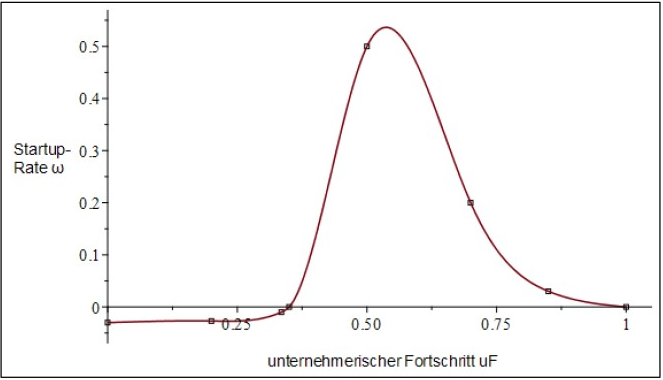

#### The following formula shows the calculation of the risk-feasible rate for different intervalls depending on the economic progress of the startup company.

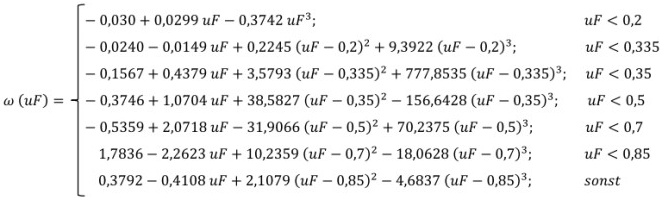

## 

#### Implementation:

In [1]:
# Create a class for this approach which defines important factors and the derivation of the enterprise value.


import numpy as np
import pandas as pd



class RF_Startup_Value():
    
    
    def __init__(self, cashflows):
        self.cashflows = cashflows
       
    
    
    def beta(self, own_beta=None, peer_beta=None, industry_beta=None, market_beta=None):
        
        if own_beta != None:
            return own_beta
        
        elif peer_beta != None:
            if (industry_beta != None) and (market_beta != None):
                return (1/3 * peer_beta + 1/3 * industry_beta + 1/3 * market_beta)
            else:
                return peer_beta
        
        elif industry_beta != None: 
            if (peer_beta != None) and (market_beta != None):
                return (1/3 * peer_beta + 1/3 * industry_beta + 1/3 * market_beta)
            elif market_beta != None:
                return (0.5 * industry_beta + 0.5 * market_beta)
            else:
                return industry_beta
        
        elif market_beta != None:
            if (peer_beta != None) and (industry_beta != None):
                return (1/3 * peer_beta + 1/3 * industry_beta + 1/3 * market_beta)
            elif industry_beta != None:
                return (0.5 * industry_beta + 0.5 * market_beta)
            else:
                return market_beta
    
        else: 
            return 1
    
    
    
    
    def risk_feasible_startup_rate(self, corporate_progress):
        
        if corporate_progress < 0.2:
            return -0.03 + 0.0299 * corporate_progress - 0.3742 * (corporate_progress**3)
        
        elif corporate_progress < 0.335:
            return -0.024 - 0.0149 * corporate_progress + 0.2245 * (corporate_progress - 0.2)**2 + 9.3922 * (corporate_progress - 0.2)**3
        
        elif corporate_progress < 0.35:
            return -0.1567 + 0.4379 * corporate_progress + 3.5793 * (corporate_progress - 0.335)**2 + 777.8535 * (corporate_progress - 0.335)**3
        
        elif corporate_progress < 0.5:
            return -0.3746 + 1.0704 * corporate_progress + 38.5827 * (corporate_progress - 0.35)**2 - 156.6428 * (corporate_progress)**3
        
        elif corporate_progress < 0.7:
            return -0.5359 + 2.0718 * corporate_progress - 31.9066 * (corporate_progress - 0.5)**2 + 70.2375 * (corporate_progress - 0.5)**3
        
        elif corporate_progress < 0.85:
            return 1.7836 - 2.2623 * corporate_progress + 10.2359 * (corporate_progress - 0.7)**2 - 18.0628 * (corporate_progress - 0.7)**3
        
        else:
             return 0.3792 - 0.4108 * corporate_progress + 2.1079 * (corporate_progress - 0.85)**2 - 4.6837 * (corporate_progress - 0.85)**3
        
        
        
    
    def discount_plan(self, i_r, corporate_progress=0.00, own_beta=None, peer_beta=None, industry_beta=None, market_beta=None, mrp=0.05):   
        
        beta_unlevered = self.beta(own_beta, peer_beta, industry_beta, market_beta)
        equity_cost = i_r + beta_unlevered * mrp   
        adjusted_equity_cost = equity_cost + self.risk_feasible_startup_rate(corporate_progress)
        
        return adjusted_equity_cost
    
    

    
    def discount_tv(self, i_r, own_beta=None, peer_beta=None, industry_beta=None, market_beta=None, mrp=0.05):
        
        beta_unlevered = self.beta(own_beta, peer_beta, industry_beta, market_beta)
        equity_cost = i_r + beta_unlevered * mrp  
        return equity_cost
    

    

    def valuation(self, i_r, corporate_progress=0.00, own_beta=None, peer_beta=None, industry_beta=None, market_beta=None, growth_rate=0.05):
        
        r_equity = self.discount_plan(i_r, corporate_progress, own_beta, peer_beta, industry_beta, market_beta)
        r_equity_capm = self.discount_tv(i_r, own_beta, peer_beta, industry_beta, market_beta)
        
        t = 1
        total_value = 0
        for cf in self.cashflows:
            discounted_cashflow = cf / ((1 + r_equity)**t)
            total_value = total_value + discounted_cashflow
            t += 1
        
        dcf_before_terminal_value = total_value
        
        T = len(self.cashflows)
        terminal_value = ((self.cashflows[-1]*(1 + growth_rate)) / (r_equity - growth_rate)) / ((1 + r_equity_capm)**T)
    
        corporate_value = dcf_before_terminal_value + terminal_value
        
        return corporate_value.astype(np.int32)
    

In [2]:
# Load the relevant data (e.g. finance data as part of a business plan):

data = pd.read_csv(r"C:\Users\user\GitHub\Valuation\Startup_Plan.csv", sep=";")

df = data.set_index(data['Position'].values)
df.drop(columns=['Position'], axis=1, inplace=True)
df

,2020,2021,2022,2023,2024,2025,2026 ff.
Revenue,290,309,330,352,376,403,407
Operational Expenses,81,84,88,93,97,102,103
Technology Expenses,59,64,69,76,82,89,90
Cash Flow before Tax,150,161,173,183,197,212,214
Tax (30%),45,48,52,55,59,64,64
Cash Flow after Tax,105,113,121,128,138,148,150


In [3]:
# Create an empty list and append the cash flows in this list.

CashFlows = []                                          # empty list

for cf in df.loc["Cash Flow after Tax", ["2021","2022","2023","2024","2025", "2026 ff."]].values:   # 2021-2025: forecast, 2026 for TV
    CashFlows.append(cf)
    
# print(CashFlows)
    

    
# Declare an object for the class, define the relevant measures and use these informations for further calculations.

rf = RF_Startup_Value(cashflows=CashFlows)             

marketBeta = 1 
peerBeta = 0.55
industryBeta = 0.76
discountRate = 0.018
growthRate=0.1
corporateProgress=0.8




print("Used Cashflows:\t\t" + str(rf.cashflows))


beta = rf.beta(industry_beta=industryBeta, market_beta=marketBeta, peer_beta=peerBeta)
print("Calculated Beta:\t" + str(round(beta, 2)))


risk = rf.risk_feasible_startup_rate(corporate_progress=corporateProgress)
print("Risk-Feasible Rate:\t" + str(round(risk, 4)) + "\t\t at corporate progress: " + str(corporateProgress*100) + " %")
print()

r_equity = rf.discount_plan(i_r=discountRate, industry_beta=industryBeta, market_beta=marketBeta, peer_beta=peerBeta, corporate_progress=corporateProgress)
print("r_equity:\t\t" + str(round(r_equity, 3)))


r_equity_capm = rf.discount_tv(i_r=discountRate, industry_beta=industryBeta, market_beta=marketBeta, peer_beta=peerBeta)
print("r_equity_capm:\t\t" + str(round(r_equity_capm, 3)))
print()


enterprise_value = rf.valuation(i_r=discountRate, corporate_progress=corporateProgress, industry_beta=industryBeta, market_beta=marketBeta, peer_beta=peerBeta, growth_rate=growthRate)
print("Enterprise Value:\t" + str(enterprise_value) + " €")


Used Cashflows:		[113, 121, 128, 138, 148, 150]
Calculated Beta:	0.77
Risk-Feasible Rate:	0.0581		 at corporate progress: 80.0 %

r_equity:		0.115
r_equity_capm:		0.057

Enterprise Value:	8696 €
